# Second Competition: Modulation format classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

#import library
import tensorflow as tf
from tensorflow import keras

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [6]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [7]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

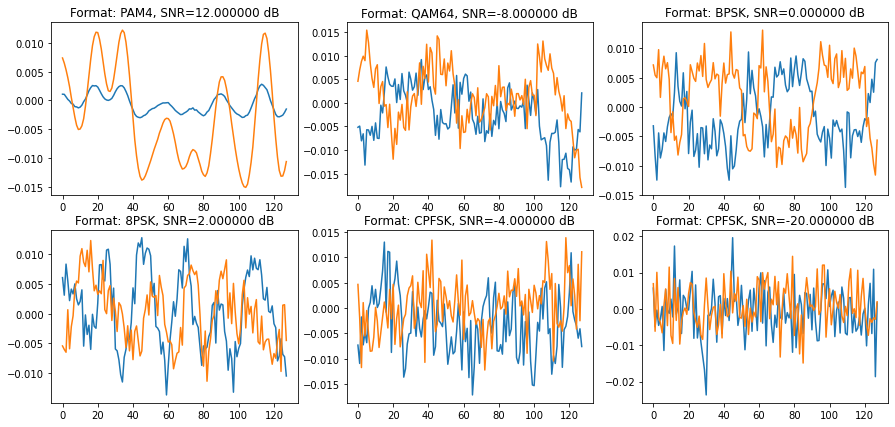

In [8]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

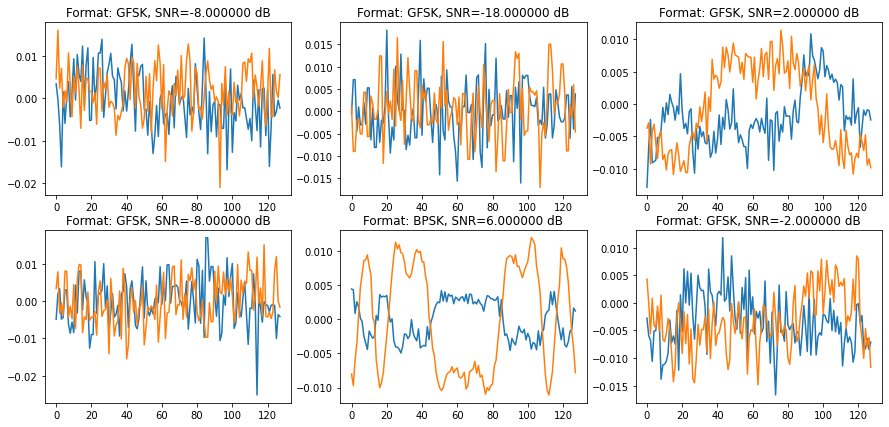

In [9]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [19]:
def CER(predictions, labels):
    return (np.sum(predictions != labels) / np.size(predictions))

In [51]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
#training and validation input data
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

#label training and validation data
Y     = np.equal(y_train_task1,4)              #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)                        #convert data type to float
Y     = Y.reshape(-1,1).transpose()            #reshape the array
Y_val = np.equal(y_valid_task1,4)              #set 0 as BPSK and 1 as GFSK
Y_val = Y_val.astype(float)                    #convert data type to float
Y_val = Y_val.reshape(-1,1).transpose()        #reshape the array 

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1)        #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range))        #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))  #Error rate training data

#callbacks function , stop the training when the desired loss is reached
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 0.001):            
            self.model.stop_training = True
callbacks = myCallback()

#build the neural networ model using keras
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[0], activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])


#loop over all SNR value
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    #compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    #fit the model
    history = model.fit(
        X_train_SNR.transpose(), Y_train_SNR.transpose(), epochs = 40,callbacks=[callbacks]
    )
    #make prediction
    Y_pred = model.predict(X_valid_SNR.transpose())
    Y_pred = Y_pred > 0.5
    Y_pred = Y_pred.astype(float).transpose()
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    
  

Train on 1291 samples
Epoch 1/40
1291/1291 [==============================] - 0s 297us/sample - loss: 0.6943 - accuracy: 0.4950
Epoch 2/40
1291/1291 [==============================] - 0s 78us/sample - loss: 0.6838 - accuracy: 0.5631
Epoch 3/40
1291/1291 [==============================] - 0s 72us/sample - loss: 0.6352 - accuracy: 0.6669
Epoch 4/40
1291/1291 [==============================] - 0s 76us/sample - loss: 0.4889 - accuracy: 0.7854
Epoch 5/40
1291/1291 [==============================] - 0s 72us/sample - loss: 0.2653 - accuracy: 0.9156
Epoch 6/40
1291/1291 [==============================] - 0s 87us/sample - loss: 0.0836 - accuracy: 0.9822
Epoch 7/40
1291/1291 [==============================] - 0s 86us/sample - loss: 0.0184 - accuracy: 0.9977
Epoch 8/40
1291/1291 [==============================] - 0s 69us/sample - loss: 0.0032 - accuracy: 1.0000
Epoch 9/40
1291/1291 [==============================] - 0s 73us/sample - loss: 0.0013 - accuracy: 1.0000
Epoch 10/40
1291/1291 [=========

1296/1296 [==============================] - 0s 76us/sample - loss: 0.0322 - accuracy: 0.9969
Epoch 8/40
1296/1296 [==============================] - 0s 94us/sample - loss: 0.0157 - accuracy: 0.9992
Epoch 9/40
1296/1296 [==============================] - 0s 88us/sample - loss: 0.0085 - accuracy: 1.0000
Epoch 10/40
1296/1296 [==============================] - 0s 62us/sample - loss: 0.0059 - accuracy: 1.0000
Epoch 11/40
1296/1296 [==============================] - 0s 57us/sample - loss: 0.0044 - accuracy: 1.0000
Epoch 12/40
1296/1296 [==============================] - 0s 58us/sample - loss: 0.0034 - accuracy: 1.0000
Epoch 13/40
1296/1296 [==============================] - 0s 58us/sample - loss: 0.0028 - accuracy: 1.0000
Epoch 14/40
1296/1296 [==============================] - 0s 58us/sample - loss: 0.0023 - accuracy: 1.0000
Epoch 15/40
1296/1296 [==============================] - 0s 71us/sample - loss: 0.0019 - accuracy: 1.0000
Epoch 16/40
1296/1296 [==============================] - 0s 

1258/1258 [==============================] - 0s 74us/sample - loss: 0.0016 - accuracy: 1.0000
Epoch 10/40
1258/1258 [==============================] - 0s 63us/sample - loss: 0.0013 - accuracy: 1.0000
Epoch 11/40
1258/1258 [==============================] - 0s 63us/sample - loss: 0.0011 - accuracy: 1.0000
Epoch 12/40
1258/1258 [==============================] - 0s 62us/sample - loss: 9.2220e-04 - accuracy: 1.0000
Train on 1256 samples
Epoch 1/40
1256/1256 [==============================] - 0s 337us/sample - loss: 0.2671 - accuracy: 0.9188
Epoch 2/40
1256/1256 [==============================] - 0s 67us/sample - loss: 0.0596 - accuracy: 0.9793
Epoch 3/40
1256/1256 [==============================] - 0s 70us/sample - loss: 0.0150 - accuracy: 0.9960
Epoch 4/40
1256/1256 [==============================] - 0s 72us/sample - loss: 0.0032 - accuracy: 1.0000
Epoch 5/40
1256/1256 [==============================] - 0s 78us/sample - loss: 0.0018 - accuracy: 1.0000
Epoch 6/40
1256/1256 [==============

Plot the classification error for each SNR value

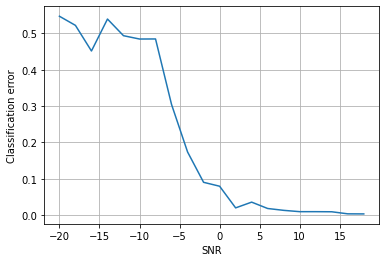

In [52]:
plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)